# Multinomial HMM
Based on an example here: https://github.com/hmmlearn/hmmlearn/issues/70 which was implementing a Categorical HMM

The `MultinomialHMM` is a generalization of `CategoricalHMM`, with the key differences being:
  - a Categorical (aka generalized Bernoulli/multinoulli) distribution models
  an outcome of a die with `n_features` possible values, i.e. it is a
  generaliztion of the Bernoulli distribution where there are `n_features`
  categories instead of the binary success/failure outcome;
  a Categorical HMM has the emission probabilities for each component
  parametrized by Categorical distributions
  - a Multinomial distribution models the outcome of `n_trials` independent
  rolls of die, each with `n_features` possible values; i.e.
    - when n_trials = 1 and n_features = 1, Multinomial is the
      Bernoulli distribution
    - when n_trials > 1 and n_features = 2, Multinomial is the
      Binomial distribution
    - when n_trials = 1 and n_features > 2, Multinomial is the
      Categorical distribution

A `MultinomialHMM` has the emission probabilities for each component parameterized
by the multinomial distribution.
    - More details: https://en.wikipedia.org/wiki/Multinomial_distribution

Based on https://github.com/hmmlearn/hmmlearn/blob/main/examples/multinomial_hmm_example.py


In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from dynamax.hidden_markov_model import MultinomialHMM

In [3]:
def sentence2counts(sentence, vocab_to_ids):
    ans = [0] * len(vocab_to_ids)
    for word, idx in vocab_to_ids.items():
        count = sentence.count(word)
        ans[idx] = count
    return ans

In [4]:
key = jr.PRNGKey(0)
# For this example, we will model the stages of a conversation,
# where each sentence is "generated" with an underlying topic, "cat" or "dog"
states = ["cat", "dog"]
id2topic = dict(zip(range(len(states)), states))

# For each topic, the probability of saying certain words can be modeled by
# a distribution over vocabulary associated with the categories
vocabulary = ["tail", "fetch", "mouse", "food"]

# Pretend that every sentence we speak only has a total of 5 words,
# i.e. we independently utter a word from the vocabulary 5 times per sentence
# we observe the following bag of words (BoW) for 8 sentences:
observations = [["tail", "mouse", "mouse", "food", "mouse"], 
                ["food", "mouse", "mouse", "food", "mouse"],
                ["tail", "mouse", "mouse", "tail", "mouse"], 
                ["food", "mouse", "food", "food", "tail"],
                ["tail", "fetch", "mouse", "food", "tail"],
                ["tail", "fetch", "fetch", "food", "fetch"],
                ["fetch", "fetch", "fetch", "food", "tail"], 
                ["food", "mouse", "food", "food", "tail"],
                ["tail", "mouse", "mouse", "tail", "mouse"], 
                ["fetch", "fetch", "fetch", "fetch", "fetch"]]

# Convert "sentences" to numbers:
vocab_to_ids = dict(zip(vocabulary, range(len(vocabulary))))

emissions = []
for sentence in observations:
    row = sentence2counts(sentence, vocab_to_ids)
    emissions.append(row)

emissions = jnp.array(emissions, dtype=int)

# pretend this is repeated, so we have more data to learn from:
emissions = jnp.tile(emissions, (5, 1))

# Add a dummy dimension since per MultinomialHMM convention
emissions = emissions[:, None, :]

In [5]:
# Set up model:
num_states = 2      # 2 discrete states
emission_dim = 1    # single multinomial observation per time step
num_classes = 4     # each multinomial observation has 4 numbers (size of vocab)
num_trials = 5      # each multinomial observation sums to 5 (length of sentence)
model = MultinomialHMM(num_states, emission_dim, num_classes, num_trials)

# Start with randomly initialized parameters
params, param_props = model.initialize(jr.PRNGKey(0))

100%|██████████| 50/50 [00:00<00:00, 79.25it/s]


Text(0, 0.5, 'log probability')

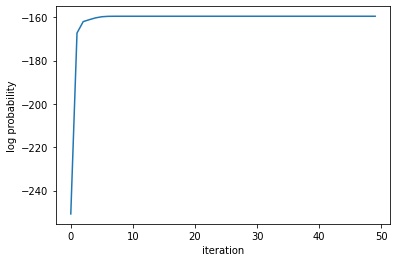

In [6]:
# Fit the model
params, lps = model.fit_em(params, param_props, emissions)

plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

In [7]:
# Infer most likely subjects
print("Topics discussed:")
states = model.most_likely_states(params, emissions)
print([id2topic[x] for x in states.tolist()])

Topics discussed:
['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog']


In [8]:
# Print estimated parameters
print("Learned emission probs:")
print(params["emissions"]["probs"])

print("Learned transition matrix:")
print(params["transitions"]["transition_matrix"])


Learned emission probs:
[[[0.25698185 0.02899423 0.4283295  0.28569448]]

 [[0.13453096 0.7295756  0.00178499 0.1341085 ]]]
Learned transition matrix:
[[0.7128132  0.2871868 ]
 [0.63953185 0.36046818]]
